In [2]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
import cv2
import time

gap_max = 0.006

nb_max_pixels = 50*50

margin = 1


class Shape(object):

    def __init__(self, gap_max=0.007, radius = 0.5, hole_radius = 0.05, randomize=True, sym_flip=False, sym_rot=1):
        self.gap_max = gap_max
        self.radius = radius
        self.hole_radius = hole_radius
        self.nb_pixels = 0
        self.x_pixels = []
        self.y_pixels = []
        self.transformations = []

        self.sym_flip = sym_flip
        self.sym_rot = sym_rot
        
        if randomize:
            self.randomize()
        

    def generate_part_part(self, radius, hole_radius, x1, y1, x2, y2): 
    
        if abs(x1 - x2) > self.gap_max or abs(y1 - y2) > self.gap_max:

            d = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)/5
            
            dx = (2 * np.random.rand() - 1) * d
            dy = (2 * np.random.rand() - 1) * d
            while dx**2 + dy**2 > d**2:
                dx = (2 * np.random.rand() - 1) * d
                dy = (2 * np.random.rand() - 1) * d
            x3 = (x1 + x2) / 2 + dx
            y3 = (y1 + y2) / 2 + dy

            while x3**2 + y3**2 > radius**2:
                dx = (2 * np.random.rand() - 1) * d
                dy = (2 * np.random.rand() - 1) * d
                while dx**2 + dy**2 > d**2:
                    dx = (2 * np.random.rand() - 1) * d
                    dy = (2 * np.random.rand() - 1) * d
                x3 = (x1 + x2) / 2 + dx
                y3 = (y1 + y2) / 2 + dy
                

            if self.generate_part_part(radius, hole_radius, x1, y1, x3, y3):
                return True

            if self.generate_part_part(radius, hole_radius, x3, y3, x2, y2):
                return True
            
        else:

            if x1**2 + y1**2 >= radius**2 or x1**2 + y1**2 < hole_radius**2:
                return True
            
            self.x_pixels.append(x1)
            self.y_pixels.append(y1)

        return False

    def generate_part(self, radius, hole_radius):

        err1, err2, err3, err4 = True, True, True, True
        
        while err1 or err2 or err3 or err4:
            nb_pixels = 0
            
            self.x_pixels = []
            self.y_pixels = []

            x1 = np.random.rand() * radius
            y1 = np.random.rand() * radius
            while x1**2 + y1**2 > radius**2 or x1**2 + y1**2 < hole_radius**2:
                x1 = np.random.rand() * radius
                y1 = np.random.rand() * radius

            x2 = -np.random.rand() * radius
            y2 = np.random.rand() * radius
            while x2**2 + y2**2 > radius**2 or x2**2 + y2**2 < hole_radius**2:
                x2 = -np.random.rand() * radius
                y2 = np.random.rand() * radius

            x3 = -np.random.rand() * radius
            y3 = -np.random.rand() * radius
            while x3**2 + y3**2 > radius**2 or x3**2 + y3**2 < hole_radius**2:
                x3 = -np.random.rand() * radius
                y3 = -np.random.rand() * radius

            x4 = np.random.rand() * radius
            y4 = -np.random.rand() * radius
            while x4**2 + y4**2 > radius**2 or x4**2 + y4**2 < hole_radius**2:
                x4 = np.random.rand() * radius
                y4 = -np.random.rand() * radius

            self.n_pixels1 = len(self.x_pixels)
            err1 = self.generate_part_part(radius, hole_radius, x1, y1, x2, y2)
            self.n_pixels2 = len(self.x_pixels)
            err2 = self.generate_part_part(radius, hole_radius, x2, y2, x3, y3)
            self.n_pixels3 = len(self.x_pixels)
            err3 = self.generate_part_part(radius, hole_radius, x3, y3, x4, y4)
            self.n_pixels4 = len(self.x_pixels)
            err4 = self.generate_part_part(radius, hole_radius, x4, y4, x1, y1)


    def randomize(self):
        self.x_pixels = []
        self.y_pixels = []

        # self.nb_pixels = 0
        
        self.generate_part(self.radius, self.hole_radius)

        self.nb_pixels = len(self.x_pixels)

        self.x_pixels = np.array(self.x_pixels)
        self.y_pixels = np.array(self.y_pixels)

        ### random rotation
        self.rotate(np.random.rand() * np.pi * 2)

        if self.sym_rot > 1:
            self.rot_symmetrize(self.sym_rot)
        if self.sym_flip:
            self.flip_symmetrize()
        
        self.x_pixels = self.x_pixels - (self.x_pixels.max() + self.x_pixels.min())/2
        self.y_pixels = self.y_pixels - (self.y_pixels.max() + self.y_pixels.min())/2

        ### resets to a squre
        self.x_pixels = self.x_pixels/(self.x_pixels.max() - self.x_pixels.min())
        self.y_pixels = self.y_pixels/(self.y_pixels.max() - self.y_pixels.min())

        w = self.x_pixels.max() - self.x_pixels.min() # = w
        h = self.y_pixels.max() - self.y_pixels.min() # = h
        
        self.wh = (1, 1)

        self.transformations = []

    def flip_diag(self):
        self.x_pixels, self.y_pixels = self.y_pixels, self.x_pixels

    def get_contour(self):
        p1 = np.stack([self.x_pixels, self.y_pixels], 1)
        p1 = np.concatenate([p1, p1[:1]], 0)
        return p1

    def rotate(self, alpha):
        ux, uy = np.cos(alpha), -np.sin(alpha)
        vx, vy = np.sin(alpha), np.cos(alpha)
        
        x = self.x_pixels * ux + self.y_pixels * uy
        y = self.x_pixels * vx + self.y_pixels * vy

        self.x_pixels = x
        self.y_pixels = y
        
        self.transformations.append(('r', alpha))
        
        w = self.x_pixels.max() - self.x_pixels.min() # = w
        h = self.y_pixels.max() - self.y_pixels.min() # = h
        
        temp_size = np.sqrt(w * h)
        self.bb = (w, h)
        self.wh = (w/temp_size, h/temp_size)

    
    def get_bb(self):
        w = self.x_pixels.max() - self.x_pixels.min()
        h = self.y_pixels.max() - self.y_pixels.min()
        return (w,h)

    def scale(self, s): 
        if isinstance(s, tuple):
            self.x_pixels = self.x_pixels*s[0]
            self.y_pixels = self.y_pixels*s[1]
        else:
            self.x_pixels = self.x_pixels*s
            self.y_pixels = self.y_pixels*s
        
        self.transformations.append(('s', s))

        w = self.x_pixels.max() - self.x_pixels.min() # = w
        h = self.y_pixels.max() - self.y_pixels.min() # = h
        
        temp_size = np.sqrt(w * h)
        # temp_size = w * h
        self.bb = (w, h)
        self.wh = (w/temp_size, h/temp_size)

    def set_wh(self, wh):
        current_w = self.x_pixels.max() - self.x_pixels.min()
        current_h = self.y_pixels.max() - self.y_pixels.min()
        
        scale = (wh[0]/current_w, wh[1]/current_h) 
        self.scale(scale)

    def set_size(self, s):
        current_size = np.sqrt(self.bb[0]*self.bb[1])
        self.scale(s/current_size)

    def clone(self):
        s = self.__class__(randomize=False)
        s.nb_pixels = copy.deepcopy(self.nb_pixels)
        s.x_pixels = np.copy(self.x_pixels)
        s.y_pixels = np.copy(self.y_pixels)
        s.n_pixels1 = copy.deepcopy(self.n_pixels1)
        s.n_pixels2 = copy.deepcopy(self.n_pixels2)
        s.n_pixels3 = copy.deepcopy(self.n_pixels3)
        s.n_pixels4 = copy.deepcopy(self.n_pixels4)
        s.wh = copy.deepcopy(self.wh)
        
        s.transformations = copy.deepcopy(self.transformations)
        
        return s
    
    def flip(self):
        self.x_pixels = - self.x_pixels

        self.transformations.append(('f', None))
    
    def subsample(self):
        # sample many intermediate points
        N = max(500//len(self.x_pixels), 1)
        xy = np.stack([self.x_pixels, self.y_pixels], 1)

        if N>1:
            a = np.linspace(0,1,N)
            xy = xy[:-1,None,:] + (xy[1:,None,:]-xy[:-1,None,:])*a[None,:,None]
            xy = xy.reshape([-1, 2])

        for i in range(1,len(xy)-1):
            xy[i] = (xy[i+1] + xy[i-1])/2 + (np.random.rand()-0.5)*(xy[i+1] - xy[i-1])[::-1] * np.array([-1,1]) /np.linalg.norm(xy[i+1] - xy[i-1]) * 0.07

        self.x_pixels = xy[:,0]
        self.y_pixels = xy[:,1]

    def smooth(self, window=10):
        xy = np.stack([self.x_pixels, self.y_pixels], 1)
        xy = np.concatenate([xy, xy[1:window]], 0)
        xy = xy.cumsum(0)
        xy = (xy[window:] - xy[:-window])/window

        self.x_pixels = xy[:,0]
        self.y_pixels = xy[:,1]
    
    def reset(self):
        
        for t, v in reversed(self.transformations):
            if t == 'r':
                self.rotate(-v)
            if t == 's':
                if isinstance(v, tuple):
                    v = (1/v[0], 1/v[1])
                else:
                    v = 1/v
                self.scale(v)
            if t == 'f':
                self.flip()
        
        self.x_pixels = self.x_pixels - (self.x_pixels.max() + self.x_pixels.min())/2
        self.y_pixels = self.y_pixels - (self.y_pixels.max() + self.y_pixels.min())/2

        self.transformations = []
        
        w = self.x_pixels.max() - self.x_pixels.min() # = w
        h = self.y_pixels.max() - self.y_pixels.min() # = h
        
        temp_size = np.sqrt(w * h)

        self.bb = (w, h)
        self.wh = (w/temp_size, h/temp_size)

    def get_hole_radius(self):
        
        img = (np.zeros((100,100)) * 255).astype(np.uint8)
        x_pixels = np.concatenate([self.x_pixels, self.x_pixels[0:1]]) 
        y_pixels = np.concatenate([self.y_pixels, self.y_pixels[0:1]]) 
        
        contours = np.stack([x_pixels,y_pixels], 1) * 70 + 50
        contours = contours.astype(np.int32)
        contours[:10,:10]
        cv2.fillPoly(img, pts =[contours], color=(255,255,255))

        dist = cv2.distanceTransform(img, cv2.DIST_L2, 5)

        idx = dist.argmax()
        rad = dist[idx//100, idx%100]
        point = np.array([idx//100, idx%100])

        point1 = (point - 50)/70
        rad1 = rad/70

        self.circle_center = point1
        self.max_radius = rad1


class ShapeCurl(Shape):

    def randomize(self):
        self.x_pixels = []
        self.y_pixels = []

        self.generate_part(self.radius, self.hole_radius)

        self.nb_pixels = len(self.x_pixels)

        self.x_pixels = np.array(self.x_pixels)
        self.y_pixels = np.array(self.y_pixels)

        ### random rotation
        self.rotate(np.random.rand() * np.pi * 2)

        self.subsample()
        
        if self.sym_rot > 1:
            self.rot_symmetrize(self.sym_rot)
        if self.sym_flip:
            self.flip_symmetrize()

        self.x_pixels = self.x_pixels - (self.x_pixels.max() + self.x_pixels.min())/2
        self.y_pixels = self.y_pixels - (self.y_pixels.max() + self.y_pixels.min())/2

        ### resets to a squre
        self.x_pixels = self.x_pixels/(self.x_pixels.max() - self.x_pixels.min())
        self.y_pixels = self.y_pixels/(self.y_pixels.max() - self.y_pixels.min())

        w = self.x_pixels.max() - self.x_pixels.min() # = w
        h = self.y_pixels.max() - self.y_pixels.min() # = h
        
        self.wh = (1, 1)


        self.transformations = []


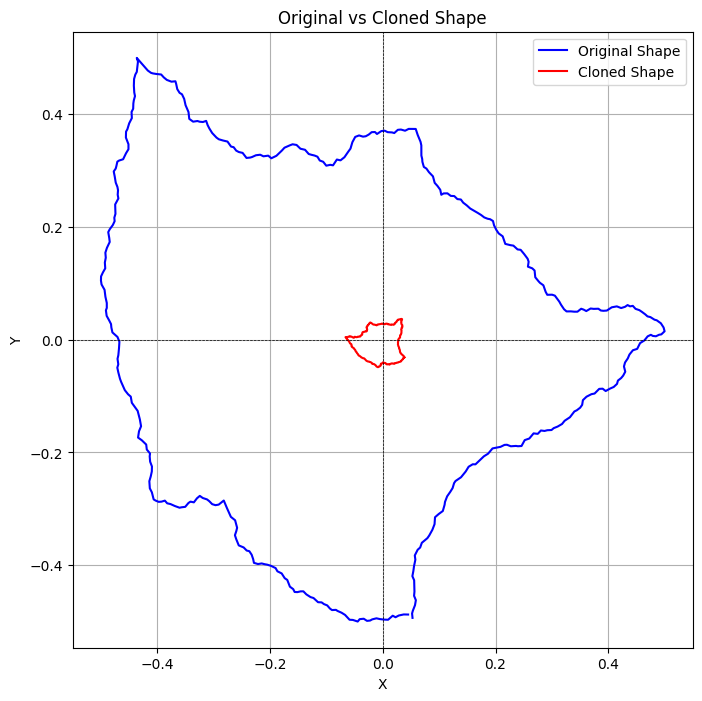

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una forma original
original_shape = Shape(radius=0.5, hole_radius=0.1, randomize=True)

# Clonar la forma
cloned_shape = original_shape.clone()

# Mover la forma clonada (escalar y rotar)
cloned_shape.scale(0.1)  # Escalar al doble de tamaño
cloned_shape.rotate(np.pi / 4)  # Rotar 45 grados

# Graficar ambas formas
plt.figure(figsize=(8, 8))

# Forma original
plt.plot(original_shape.x_pixels, original_shape.y_pixels, label="Original Shape", color="blue")

# Forma clonada
plt.plot(cloned_shape.x_pixels, cloned_shape.y_pixels, label="Cloned Shape", color="red")

# Configuración del gráfico
plt.title("Original vs Cloned Shape")
plt.xlabel("X")
plt.ylabel("Y")
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.legend()
plt.grid()
plt.axis("equal")

# Mostrar la imagen
plt.show()

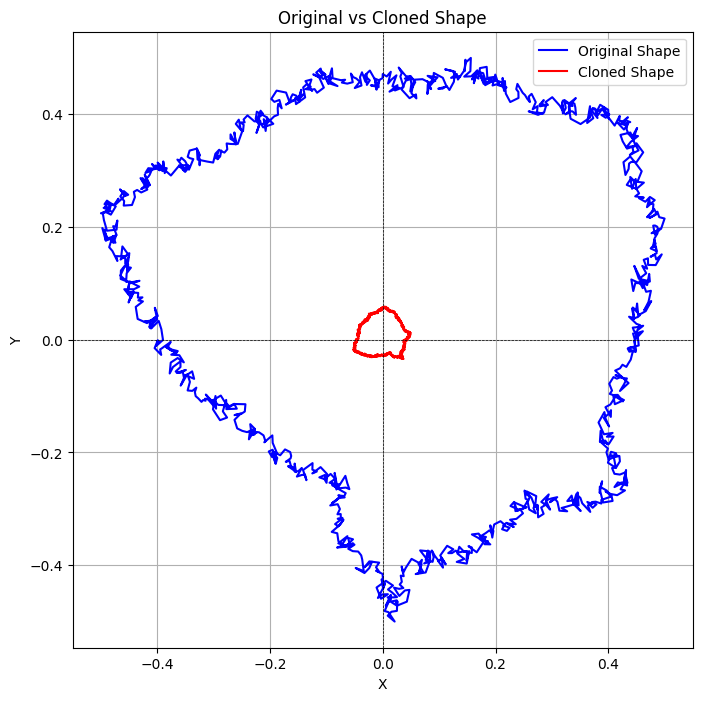

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una forma original
original_shape = ShapeCurl(radius=1, hole_radius=0.5, randomize=True)

# Clonar la forma
cloned_shape = original_shape.clone()

# Mover la forma clonada (escalar y rotar)
cloned_shape.scale(0.1)  # Escalar al doble de tamaño
cloned_shape.rotate(np.pi / 4)  # Rotar 45 grados

# Graficar ambas formas
plt.figure(figsize=(8, 8))

# Forma original
plt.plot(original_shape.x_pixels, original_shape.y_pixels, label="Original Shape", color="blue")

# Forma clonada
plt.plot(cloned_shape.x_pixels, cloned_shape.y_pixels, label="Cloned Shape", color="red")

# Configuración del gráfico
plt.title("Original vs Cloned Shape")
plt.xlabel("X")
plt.ylabel("Y")
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.legend()
plt.grid()
plt.axis("equal")

# Mostrar la imagen
plt.show()

In [5]:
class ShapeFourierFromCircularPoints(Shape):
    def __init__(self, total_points=10000, selected_points=30, num_fourier_terms=15, seed=None):
        super().__init__(randomize=False)
        self.total_points = total_points
        self.selected_points = selected_points
        self.num_fourier_terms = num_fourier_terms
        self.seed = seed
        self.randomize()

    def randomize(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        # Paso 1: puntos uniformes sobre el círculo
        t_full = np.linspace(0, 1, self.total_points, endpoint=False)
        x_full = np.cos(2 * np.pi * t_full)
        y_full = np.sin(2 * np.pi * t_full)

        # Paso 2: selección aleatoria de puntos
        indices = np.sort(np.random.choice(len(t_full), self.selected_points, replace=False))
        t_sel = t_full[indices]
        x_sel = x_full[indices]
        y_sel = y_full[indices]

        # Paso 3: interpolar con Fourier (mínimos cuadrados)
        def fit_fourier(t, f, N):
            A = [np.ones_like(t)]
            for k in range(1, N + 1):
                A.append(np.cos(2 * np.pi * k * t))
                A.append(np.sin(2 * np.pi * k * t))
            A = np.stack(A, axis=1)
            coeffs = np.linalg.lstsq(A, f, rcond=None)[0]
            return coeffs

        def eval_fourier(coeffs, t):
            N = (len(coeffs) - 1) // 2
            result = coeffs[0] * np.ones_like(t)
            for k in range(1, N + 1):
                result += coeffs[2 * k - 1] * np.cos(2 * np.pi * k * t)
                result += coeffs[2 * k] * np.sin(2 * np.pi * k * t)
            return result

        cx = fit_fourier(t_sel, x_sel, self.num_fourier_terms)
        cy = fit_fourier(t_sel, y_sel, self.num_fourier_terms)

        t_curve = np.linspace(0, 1, 1000)
        x_curve = eval_fourier(cx, t_curve)
        y_curve = eval_fourier(cy, t_curve)

        # Normalización estándar
        x_curve -= (x_curve.max() + x_curve.min()) / 2
        y_curve -= (y_curve.max() + y_curve.min()) / 2
        x_curve /= (x_curve.max() - x_curve.min())
        y_curve /= (y_curve.max() - y_curve.min())

        self.x_pixels = x_curve
        self.y_pixels = y_curve
        self.nb_pixels = len(x_curve)
        self.wh = (1, 1)
        self.transformations = []


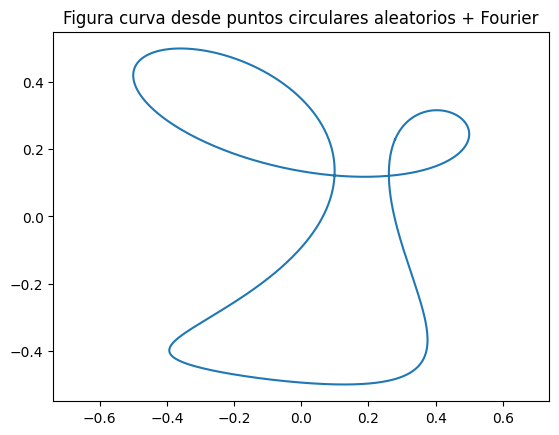

In [6]:
shape = ShapeFourierFromCircularPoints(total_points=100, selected_points=5, num_fourier_terms=3, seed=None)
contour = shape.get_contour()

plt.plot(contour[:, 0], contour[:, 1])
plt.axis("equal")
plt.title("Figura curva desde puntos circulares aleatorios + Fourier")
plt.show()

In [7]:
class SmoothShapeFromShape(Shape):
    def __init__(self, base_shape: Shape, n_sampled_points=100, fourier_terms=20, seed=None):
        super().__init__(randomize=False)
        self.n_sampled_points = n_sampled_points
        self.fourier_terms = fourier_terms
        self.seed = seed
        self.base_shape = base_shape
        self.randomize()

    def randomize(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        # Paso 1: usar figura base ya generada
        base_contour = self.base_shape.get_contour()
        total = len(base_contour)

        # Paso 2: muestreo equiespaciado
        indices = np.linspace(0, total - 1, self.n_sampled_points, dtype=int)
        t_sel = np.linspace(0, 1, self.n_sampled_points)
        x_sel = base_contour[indices, 0]
        y_sel = base_contour[indices, 1]

        # Paso 3: ajuste de Fourier
        def fit_fourier(t, f, N):
            A = [np.ones_like(t)]
            for k in range(1, N + 1):
                A.append(np.cos(2 * np.pi * k * t))
                A.append(np.sin(2 * np.pi * k * t))
            A = np.stack(A, axis=1)
            coeffs = np.linalg.lstsq(A, f, rcond=None)[0]
            return coeffs

        def eval_fourier(coeffs, t):
            N = (len(coeffs) - 1) // 2
            result = coeffs[0] * np.ones_like(t)
            for k in range(1, N + 1):
                result += coeffs[2 * k - 1] * np.cos(2 * np.pi * k * t)
                result += coeffs[2 * k] * np.sin(2 * np.pi * k * t)
            return result

        cx = fit_fourier(t_sel, x_sel, self.fourier_terms)
        cy = fit_fourier(t_sel, y_sel, self.fourier_terms)

        t_curve = np.linspace(0, 1, 1000)
        x_curve = eval_fourier(cx, t_curve)
        y_curve = eval_fourier(cy, t_curve)

        # Normalizar como en Shape
        x_curve -= (x_curve.max() + x_curve.min()) / 2
        y_curve -= (y_curve.max() + y_curve.min()) / 2
        x_curve /= (x_curve.max() - x_curve.min())
        y_curve /= (y_curve.max() - y_curve.min())

        self.x_pixels = x_curve
        self.y_pixels = y_curve
        self.nb_pixels = len(x_curve)
        self.wh = (1, 1)
        self.transformations = []


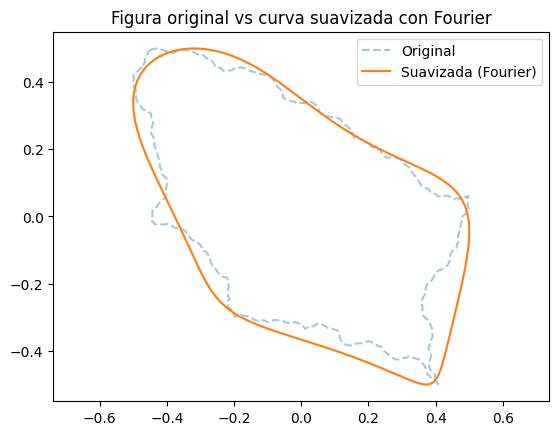

In [8]:
shape_base = Shape()
shape_smooth = SmoothShapeFromShape(
    base_shape=shape_base,
    n_sampled_points=80,
    fourier_terms=4,
    seed=None
)

# Mostrar resultado
contour_smooth = shape_smooth.get_contour()
contour_base = shape_base.get_contour()

plt.plot(contour_base[:, 0], contour_base[:, 1], '--', label="Original", alpha=0.4)
plt.plot(contour_smooth[:, 0], contour_smooth[:, 1], label="Suavizada (Fourier)")
plt.axis("equal")
plt.title("Figura original vs curva suavizada con Fourier")
plt.legend()
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class ShapeRigid(Shape):
    def __init__(self, kind='polygon', sides=3, randomize=True):
        self.kind = kind
        self.sides = sides
        super().__init__(randomize=randomize)

    def randomize(self):
        self.x_pixels = []
        self.y_pixels = []

        if self.kind == 'polygon':
            theta = np.linspace(0, 2 * np.pi, self.sides, endpoint=False)
            # Rota para que un vértice apunte hacia arriba
            theta += np.pi / 2
            self.x_pixels = np.cos(theta)
            self.y_pixels = np.sin(theta)

        elif self.kind == 'arrow':
            # Forma de flecha "↣"
            pts = np.array([
                [-0.5,  0.2],
                [-0.5, -0.2],
                [ 0.2, -0.2],
                [ 0.2, -0.5],
                [ 0.5,  0.0],
                [ 0.2,  0.5],
                [ 0.2,  0.2],
            ])
            self.x_pixels, self.y_pixels = pts[:, 0], pts[:, 1]
        
        elif self.kind == 'arrow_line':
            pts = np.array([
                [0.5, 0.0],
                [-0.5, 0.0],
                [-0.2, 0.3],
                [-0.5, 0.0],
                [-0.2, -0.3],
            ])
            self.x_pixels, self.y_pixels = pts[:, 0], pts[:, 1]


        self.nb_pixels = len(self.x_pixels)
        self.x_pixels = np.array(self.x_pixels)
        self.y_pixels = np.array(self.y_pixels)

        # Centrar
        self.x_pixels -= (self.x_pixels.max() + self.x_pixels.min()) / 2
        self.y_pixels -= (self.y_pixels.max() + self.y_pixels.min()) / 2

        # Normalizar a [-0.5, 0.5] en la dimensión más grande
        w = self.x_pixels.max() - self.x_pixels.min()
        h = self.y_pixels.max() - self.y_pixels.min()
        scale = 1 / max(w, h)
        self.x_pixels *= scale
        self.y_pixels *= scale

        self.bb = (w, h)
        self.wh = (w, h)
        self.transformations = []


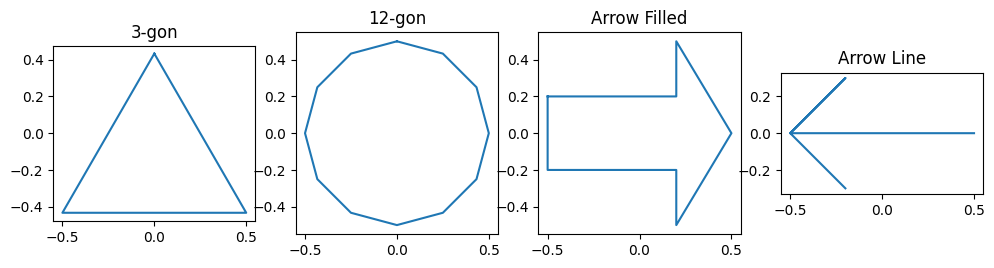

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

for ax, sides in zip(axs, [3, 12, "arrow", "arrow_line"]):
    if sides == "arrow":
        shape = ShapeRigid(kind='arrow')
        title = "Arrow Filled"
    elif sides == "arrow_line":
        shape = ShapeRigid(kind='arrow_line')
        title = "Arrow Line"
    else:
        shape = ShapeRigid(kind='polygon', sides=sides)
        title = f"{sides}-gon"
    
    contour = shape.get_contour()

    if sides == "arrow_line":
        contour = contour[:-1]

    ax.plot(contour[:, 0], contour[:, 1])
    ax.set_title(title)
    ax.set_aspect('equal')

plt.show()


In [205]:
class ShapeSym(Shape):
    def __init__(self, base_shape: Shape):
        super().__init__(randomize=False)
        self.base_shape = base_shape
        self.symmetrize()
    
    def symmetrize(self):

        # Manejo por casos para simplificar continuidad según cómo
        # estén ordenadas coordenadas de figura base

        # Se puede mover eje cambiando el cutoff, habría que agregar un paso de centrado

        if self.base_shape.x_pixels[0] < 0:
            
            # Tomamos un lado de la figura
            mask = self.base_shape.x_pixels >= 0
            self.x_pixels = self.base_shape.x_pixels[mask][::-1]
            self.y_pixels = self.base_shape.y_pixels[mask][::-1]

            # Reflejamos
            self.flip()

            # Concatenamos nuevamente el lado original sin reflejar
            self.x_pixels = np.concatenate([self.x_pixels, self.base_shape.x_pixels[mask]])
            self.y_pixels = np.concatenate([self.y_pixels, self.base_shape.y_pixels[mask]])
            self.nb_pixels = len(self.x_pixels)

        elif self.base_shape.x_pixels[0] >= 0:

            mask = self.base_shape.x_pixels < 0
            self.x_pixels = self.base_shape.x_pixels[mask][::-1]
            self.y_pixels = self.base_shape.y_pixels[mask][::-1]

            self.flip()

            self.x_pixels = np.concatenate([self.x_pixels, self.base_shape.x_pixels[mask]])
            self.y_pixels = np.concatenate([self.y_pixels, self.base_shape.y_pixels[mask]])
            self.nb_pixels = len(self.x_pixels)

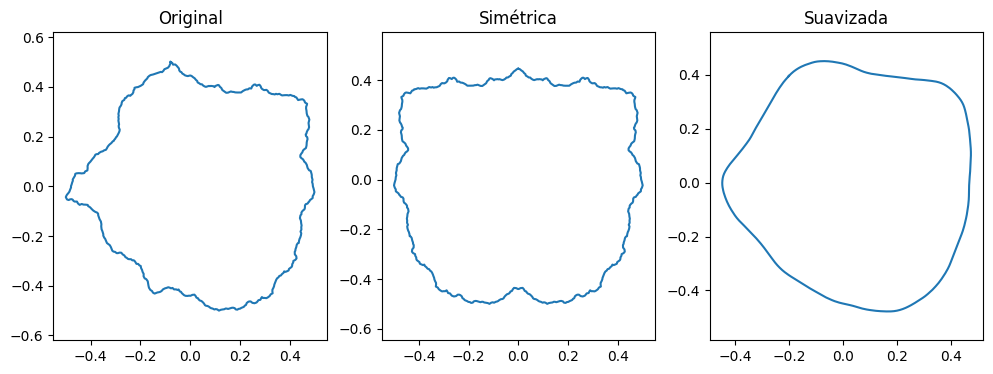

In [206]:
# Ejemplo 
shape_base = Shape()

shape_sym = ShapeSym(base_shape=shape_base)
contour_base = shape_base.get_contour()
contour_sym = shape_sym.get_contour()
# print(contour_sym)

shape_base.smooth(window=50) # método nativo de Shape para suavizar
smooth_contour = shape_base.get_contour()

# plot all 3 in separate graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(contour_base[:, 0], contour_base[:, 1], label="Original")
plt.title("Original")
plt.axis("equal")

plt.subplot(1, 3, 2)
plt.plot(contour_sym[:, 0], contour_sym[:, 1],  label="Simétrica")
plt.title("Simétrica")
plt.axis("equal")

plt.subplot(1, 3, 3)
plt.plot(smooth_contour[:, 0], smooth_contour[:, 1], label="Suavizada")
plt.title("Suavizada")
plt.axis("equal")

plt.show()

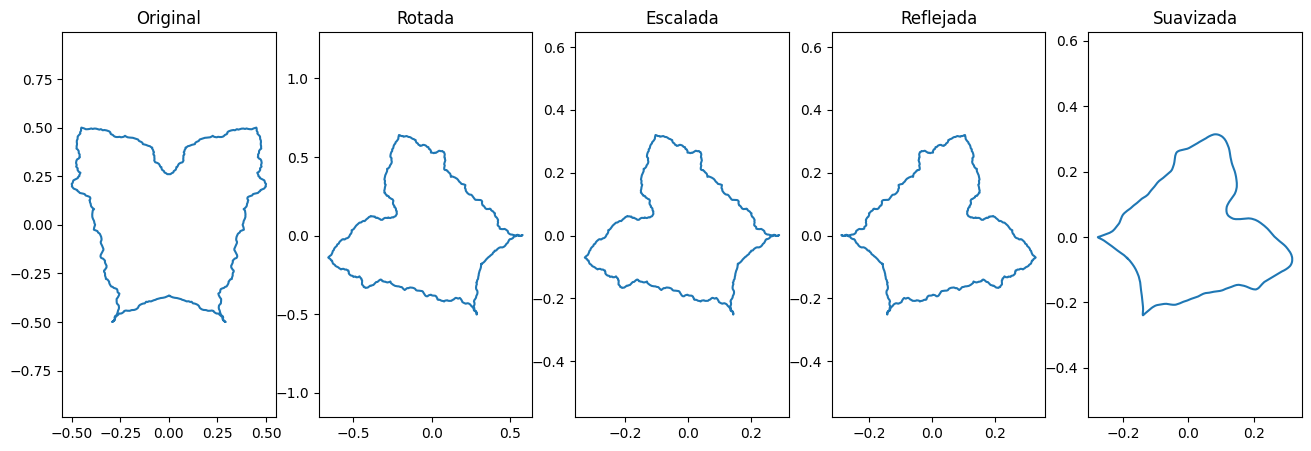

In [190]:
# Ejemplo transformaciones sobre ShapeSym

shape_base = Shape()

shape_sym = ShapeSym(base_shape=shape_base)
org_contour = shape_sym.get_contour()

shape_sym.rotate(np.pi/3)
rot_contour = shape_sym.get_contour()

shape_sym.scale(0.5)
scale_contour = shape_sym.get_contour()

shape_sym.flip()
flip_contour = shape_sym.get_contour()

shape_sym.smooth(window=15)
smooth_contour = shape_sym.get_contour()

# plot all 5 in separate graphs
plt.figure(figsize=(16, 5))
plt.subplot(1, 5, 1)
plt.plot(org_contour[:, 0], org_contour[:, 1], label="Original")
plt.title("Original")
plt.axis("equal")

plt.subplot(1, 5, 2)
plt.plot(rot_contour[:, 0], rot_contour[:, 1], label="Rotada")
plt.title("Rotada")
plt.axis("equal")

plt.subplot(1, 5, 3)
plt.plot(scale_contour[:, 0], scale_contour[:, 1], label="Escalada")
plt.title("Escalada")
plt.axis("equal")

plt.subplot(1, 5, 4)
plt.plot(flip_contour[:, 0], flip_contour[:, 1], label="Reflejada")
plt.title("Reflejada")
plt.axis("equal")

plt.subplot(1, 5, 5)
plt.plot(smooth_contour[:, 0], smooth_contour[:, 1], label="Suavizada")
plt.title("Suavizada")
plt.axis("equal")

plt.show()